In [1]:
%matplotlib inline

In [2]:
!pip3 install pickle5

     |████████████████████████████████| 256 kB 9.4 MB/s 


In [3]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F

import torch.optim as optim
import pandas as  pd

import random
import os

import pickle5 as pickle
import pandas as pd
import math

In [4]:
class config:
    seed = 42

In [5]:
def seed_everything(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)  # type: ignore
    torch.backends.cudnn.deterministic = True  # type: ignore
    torch.backends.cudnn.benchmark = True  # type: ignore

In [6]:
seed_everything(config.seed)

In [7]:
batch_size = 1

In [8]:
def augment(x,y,size,half_size,data_count,flip_yn,rotation_degree,affine_rate):
    
    
    if flip_yn == 1:
        x_return = x[:, :, :, ::-1]
    else :
        x_return = x    
    if rotation_degree != 0:
        rotation = []
        #회전 좌표 구하기
        for i in range(-half_size,half_size+1,1):
            for j in range(-half_size,half_size+1,1):
                if i*j !=0 :
                    #처음 좌표
                    coor_y = half_size-j
                    coor_x = i+half_size
                    if coor_y > half_size : coor_y = coor_y-1
                    if coor_x > half_size : coor_x = coor_x-1

                    #변경 좌표
                    coor_y_2 = half_size-(i*math.sin(math.pi * (rotation_degree / 180)) + j*math.cos(math.pi * (rotation_degree / 180)))
                    coor_x_2 = (i*math.cos(math.pi * (rotation_degree / 180)) - j*math.sin(math.pi * (rotation_degree / 180)))+half_size
                    if coor_y_2 > half_size : coor_y_2 = coor_y_2-1
                    if coor_x_2 > half_size : coor_x_2 = coor_x_2-1

                    rotation.append([coor_y,coor_x,coor_y_2,coor_x_2])
        data_rotation = pd.DataFrame(rotation)
        data_rotation = data_rotation[(data_rotation[2]>0) & (data_rotation[3]>0)&(data_rotation[2]<size) & (data_rotation[3]<size)]
        x_rotation = np.zeros((data_count,3,size,size))
        for i in range(size) :
            for j in range(size):
                data_rotation_2 = data_rotation[ ((round(data_rotation[2])==i)|(round(data_rotation[2],0)==i)) & ((round(data_rotation[3])==j)|(round(data_rotation[3],0)==j)) ]
                if len(data_rotation_2) > 0:
                    x_rotation[:,:,i,j] = np.mean(x_return[:,:,data_rotation_2[0],data_rotation_2[1]],axis=2)
        x_return = x_rotation

    if affine_rate != 0 :
        pixel = int(size*affine_rate)
        dummy = np.zeros((data_count,3,size,pixel))
        x_return = np.concatenate((dummy,x_return[:,:,:,:-pixel]),axis=3)
        dummy = np.zeros((data_count,3,pixel,size))
        x_return = np.concatenate((dummy,x_return[:,:,:-pixel,:]),axis=2)

    y_return = y
    return x_return,y_return

In [9]:
### transform 설정

transform_array = []
#transform_array.append(transform0)
for i in [0]:#[0,1]:
    for j in [5]:#[0,5,15]:
        for k in [0,0.1,0.2,0.3,0.4]:
            transform1  = [i,j,k]  
            transform_array.append(transform1)



In [10]:
with open('/content/drive/MyDrive/imagenet/32/train_data', 'rb') as fo:
    d = pickle.load(fo)
x = d['data']
y = d['labels']  

x_train  =  torch.FloatTensor(x)  
y_train  =  torch.LongTensor(y)

trainset0 = torch.utils.data.TensorDataset(x_train, y_train)
trainloader0 = torch.utils.data.DataLoader(trainset0, batch_size=batch_size, shuffle=False)

trainset_array = []
trainloader_array = []


for i in range(len(transform_array)):
    
    x_augment, y_augment   =  augment(x,y,32,16,len(x),transform_array[i][0],transform_array[i][1],transform_array[i][2])

    x_augment  =  torch.FloatTensor(x_augment.copy())  
    y_augment  =  torch.LongTensor(y_augment)

        
    trainset1 = torch.utils.data.TensorDataset(x_augment, y_augment)
    trainloader1 = torch.utils.data.DataLoader(trainset1, batch_size, shuffle=False)

    trainset_array.append(trainset1)
    trainloader_array.append(trainloader1)


In [11]:
trainset1

In [12]:
# functions to show an image

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


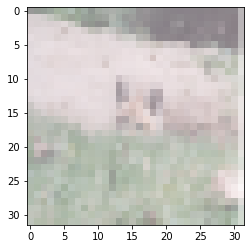

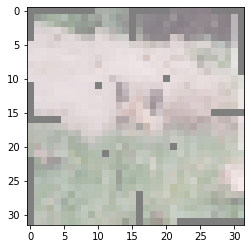

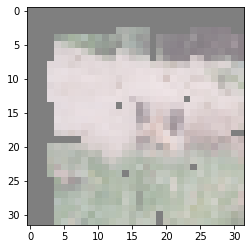

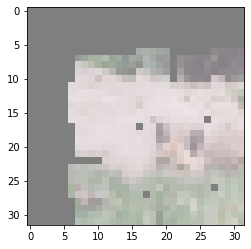

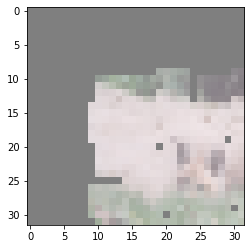

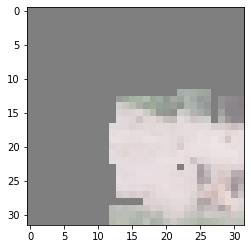

In [13]:
# get some random training images
dataiter0 = iter(trainloader0)
images0, labels0 = dataiter0.next()

# show images
imshow(torchvision.utils.make_grid(images0))
# print labels
#print(' '.join('%5s' % classes[labels0[j]] for j in range(batch_size)))
#####################################################################################

for i in range(len(transform_array)):
    dataiter1 = iter(trainloader_array[i])
    images1, labels1 = dataiter1.next()
    imshow(torchvision.utils.make_grid(images1))    


In [ ]:
import cv2 
from google.colab.patches import cv2_imshow

In [ ]:
def hist_save(hist_array,dataloader) :
    for i, data in enumerate(dataloader, 0):
        inputs, labels = data
        hsv = cv2.cvtColor(np.transpose(inputs[0], (1,2,0)).numpy(), cv2.COLOR_BGR2HSV)
        hist = cv2.calcHist([hsv], [0,1], None, [180,256], [0,180,0, 256])
        cv2.normalize(hist, hist, 0, 1, cv2.NORM_MINMAX)
        hist_array.append(hist)
        if i == 499 :
            break  

In [ ]:
hist_array = []

hist_0 = [] 
hist_save(hist_0,trainloader0)


hist_elements_array = []   
for i in range(len(transform_array)):
    hist_elements_array = []    
    hist_save(hist_elements_array,trainloader_array[i])
    hist_array.append(hist_elements_array)

In [ ]:
def hist_sim(hist_1,hist_2):
    ret_total = 0
    for i in range(500):
        ret = cv2.compareHist(hist_1[i], hist_2[i], cv2.HISTCMP_CORREL)
        ret_total = ret_total+ret
    print(ret_total/500)   

In [ ]:
for i in range(len(transform_array)):
    print(i)
    hist_sim(hist_0,hist_array[i])

0
0.8297637348231345
1
0.5494895689517633
2
0.4284423294217392
